In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 1. Load just a sample for now (optional, remove nrows later)
df = pd.read_csv(
    r"E:/socialdata/Taxi_Trips_cleaned.csv",
    #nrows=500_000,  # remove this line once tested
    low_memory=False
)

In [3]:
# 2. Explicit datetime parsing
df["Trip Start Timestamp"] = pd.to_datetime(
    df["Trip Start Timestamp"],
    format="%m/%d/%Y %I:%M:%S %p",
    errors="coerce"  # bad values become NaT instead of crashing
)
df["Trip End Timestamp"] = pd.to_datetime(
    df["Trip End Timestamp"],
    format="%m/%d/%Y %I:%M:%S %p",
    errors="coerce"
)

# 3. Continue with feature engineering (same as before)
df["trip_duration_min"] = (df["Trip End Timestamp"] - df["Trip Start Timestamp"]).dt.total_seconds() / 60
df["avg_speed_mph"] = df["Trip Miles"] / (df["trip_duration_min"] / 60)
df["tip_rate"] = df["Tips"] / df["Fare"]

df["start_year"] = df["Trip Start Timestamp"].dt.year
df["start_month"] = df["Trip Start Timestamp"].dt.month
df["start_hour"] = df["Trip Start Timestamp"].dt.hour
df["weekday"] = df["Trip Start Timestamp"].dt.day_name()

# 4. Show a preview
print(df.head())


  Trip Start Timestamp  Trip End Timestamp  Trip Seconds  Trip Miles   Fare  \
0  2019-06-29 23:00:00 2019-06-29 23:15:00         307.0        0.40   4.75   
1  2023-03-31 07:45:00 2023-03-31 08:30:00        2161.0        8.98  30.00   
2  2020-09-14 15:15:00 2020-09-14 15:30:00        1368.0        2.87  13.75   
3  2020-09-26 00:45:00 2020-09-26 01:00:00         780.0        4.70  15.00   
4  2022-08-21 19:45:00 2022-08-21 20:15:00        2004.0       15.45  39.50   

   Tips  Tolls  Extras  Trip Total Payment Type  ...  \
0   0.0    0.0     1.0        5.75         Cash  ...   
1   0.0    0.0     1.0       31.00       Prcard  ...   
2   0.0    0.0     0.0       13.75       Prcard  ...   
3   0.0    0.0     0.0       15.00         Cash  ...   
4   9.0    0.0     5.0       54.00       Mobile  ...   

  Pickup Centroid Longitude  Dropoff Centroid Latitude  \
0                -87.628874                  41.892042   
1                -87.572782                  41.660136   
2             

A. General trip overview

In [4]:
# Total number of trips
print("Total valid trips:", len(df))

# Fare and trip distance summary
print(df[["Fare", "Trip Miles", "Trip Total", "tip_rate"]].describe())


Total valid trips: 14705774


C:\Users\Jakub Nowak\AppData\Roaming\Python\Python312\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


               Fare    Trip Miles    Trip Total      tip_rate
count  1.470376e+07  1.470552e+07  1.470376e+07  1.469250e+07
mean   1.445570e+01  3.894583e+00  1.738000e+01           inf
std    4.038865e+01  1.236756e+01  4.586787e+01           NaN
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
25%    6.050000e+00  6.000000e-01  7.250000e+00  0.000000e+00
50%    8.500000e+00  1.390000e+00  1.025000e+01  0.000000e+00
75%    1.550000e+01  3.780000e+00  1.800000e+01  2.187500e-01
max    9.900260e+03  3.460000e+03  9.948470e+03           inf


B. Temporal trends

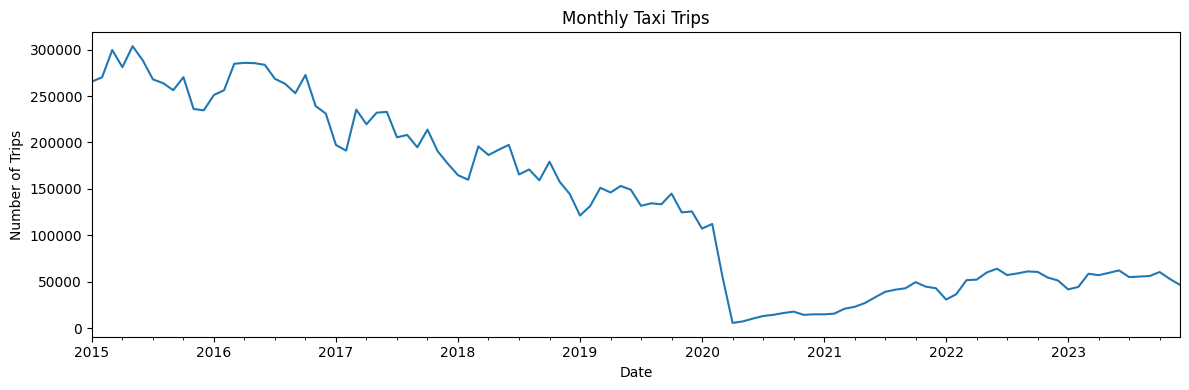

In [5]:
# 1. Group trips by year and month
monthly_trips = (
    df.groupby(["start_year", "start_month"])
    .size()
    .rename("trip_count")
    .reset_index()
)

# 2. Rename columns so pandas can parse them as a date
monthly_trips_for_date = monthly_trips[["start_year", "start_month"]].copy()
monthly_trips_for_date.columns = ["year", "month"]
monthly_trips_for_date["day"] = 1

# 3. Convert to datetime
monthly_trips["year_month"] = pd.to_datetime(monthly_trips_for_date)

# 4. Plot
monthly_trips.set_index("year_month")["trip_count"].plot(
    figsize=(12, 4),
    title="Monthly Taxi Trips"
)
plt.ylabel("Number of Trips")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

C. Tip behavior

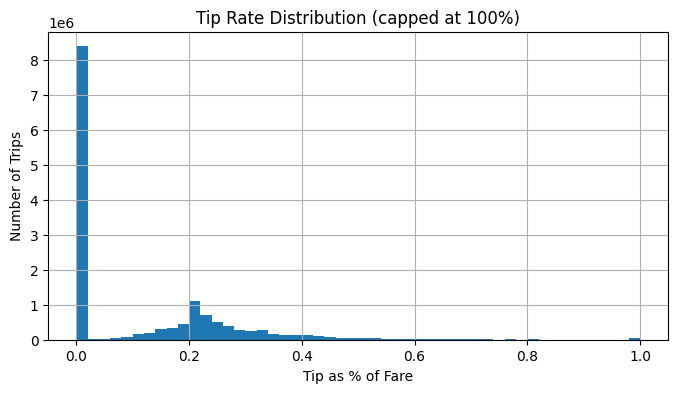

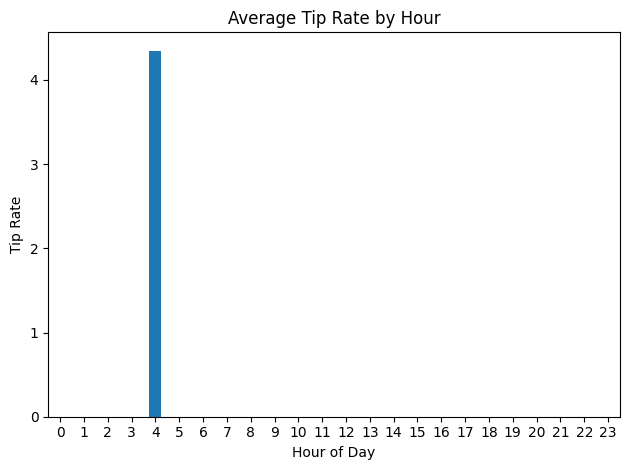

In [6]:
# Distribution of tip percentage
df["tip_rate"].clip(upper=1).hist(bins=50, figsize=(8,4))
plt.title("Tip Rate Distribution (capped at 100%)")
plt.xlabel("Tip as % of Fare")
plt.ylabel("Number of Trips")
plt.show()

# Average tip rate by hour of day
hourly_tip = df.groupby("start_hour")["tip_rate"].mean()
hourly_tip.plot(kind="bar", title="Average Tip Rate by Hour")
plt.ylabel("Tip Rate")
plt.xlabel("Hour of Day")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


D. Speed outliers

In [7]:
# Quick filter: which trips exceeded 70 mph?
fast_trips = df[df["avg_speed_mph"] > 70]

print("Trips faster than 70 mph:", len(fast_trips))
print(fast_trips[["Trip Miles", "trip_duration_min", "avg_speed_mph"]].head())

# Optional: remove absurd values for downstream analysis
df = df[(df["avg_speed_mph"] > 0) & (df["avg_speed_mph"] < 100)]


Trips faster than 70 mph: 3903839
    Trip Miles  trip_duration_min  avg_speed_mph
9         1.43                0.0            inf
13        0.40                0.0            inf
20        1.21                0.0            inf
24        0.70                0.0            inf
29        0.37                0.0            inf


E. Trip distribution by weekday

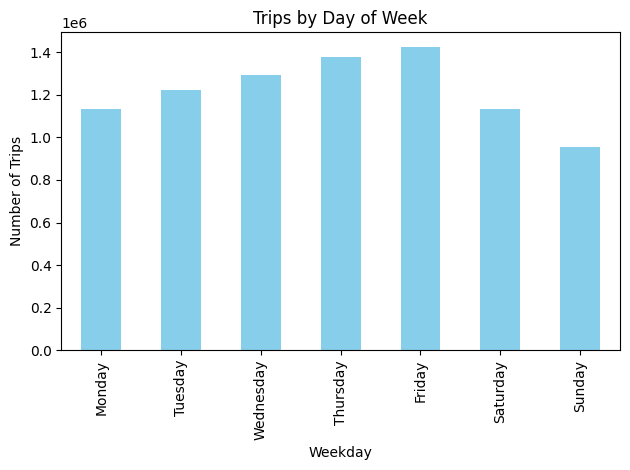

In [8]:
weekday_summary = df["weekday"].value_counts().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)

weekday_summary.plot(kind="bar", title="Trips by Day of Week", color="skyblue")
plt.ylabel("Number of Trips")
plt.xlabel("Weekday")
plt.tight_layout()
plt.show()


F. Map of pickup locations (if lat/lon available)

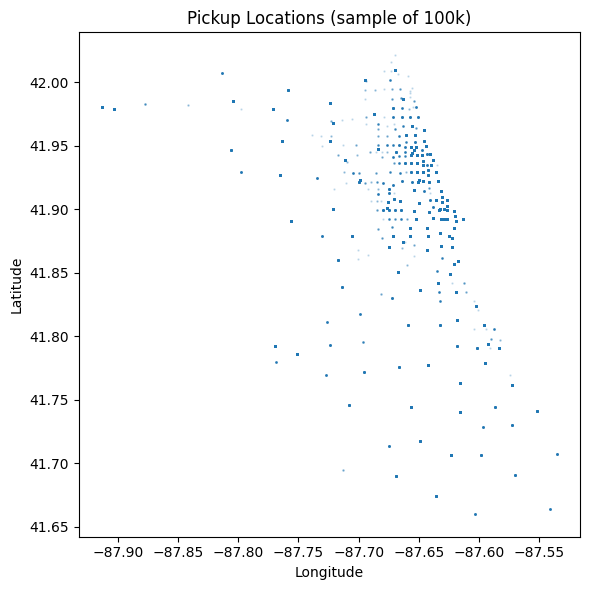

In [9]:
# Drop NaNs and take a sample for speed
pickup_sample = df.dropna(subset=["Pickup Centroid Latitude", "Pickup Centroid Longitude"]).sample(n=100000, random_state=1)

plt.figure(figsize=(6, 6))
plt.scatter(
    pickup_sample["Pickup Centroid Longitude"],
    pickup_sample["Pickup Centroid Latitude"],
    s=0.5, alpha=0.2
)
plt.title("Pickup Locations (sample of 100k)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


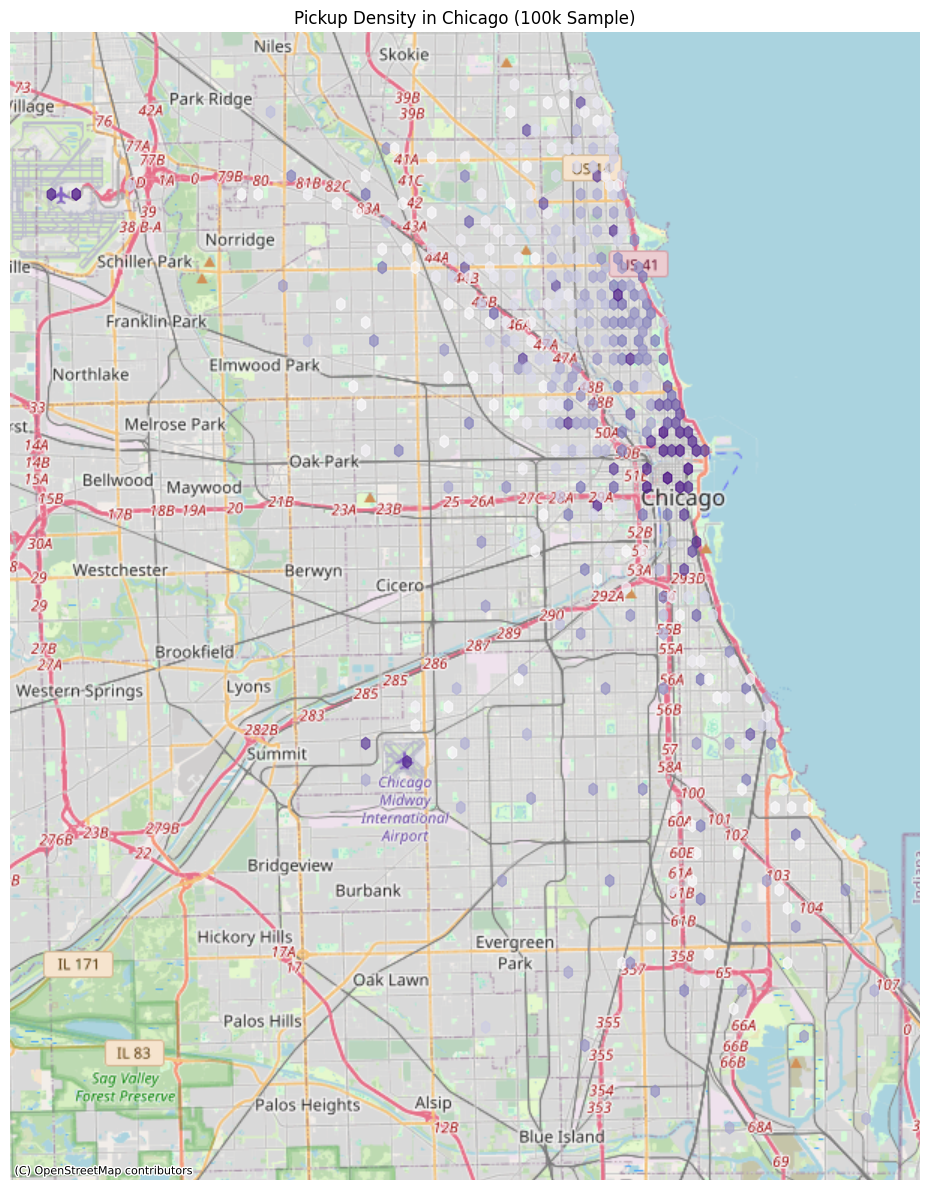

In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point

# Drop rows with missing pickup or dropoff coords
sample = df.dropna(subset=[
    "Pickup Centroid Latitude", "Pickup Centroid Longitude",
    "Dropoff Centroid Latitude", "Dropoff Centroid Longitude"
]).sample(n=1000000, random_state=1)

# Create GeoDataFrames for pickup and dropoff points
pickup_geometry = [Point(xy) for xy in zip(sample["Pickup Centroid Longitude"], sample["Pickup Centroid Latitude"])]
dropoff_geometry = [Point(xy) for xy in zip(sample["Dropoff Centroid Longitude"], sample["Dropoff Centroid Latitude"])]

gdf_pickup = gpd.GeoDataFrame(sample, geometry=pickup_geometry, crs="EPSG:4326").to_crs(epsg=3857)
gdf_dropoff = gpd.GeoDataFrame(sample, geometry=dropoff_geometry, crs="EPSG:4326").to_crs(epsg=3857)

# Plot
# Plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot hexbins for pickup locations
gdf_pickup.plot(ax=ax, alpha=0)  # Just to set the extent
ax.hexbin(
    gdf_pickup.geometry.x, 
    gdf_pickup.geometry.y, 
    gridsize=100, 
    cmap='Purples', 
    bins='log', 
    alpha=0.7
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title("Pickup Density in Chicago (100k Sample)")
plt.tight_layout()
plt.show()



Trip duration vs. distance (does time scale with miles?)

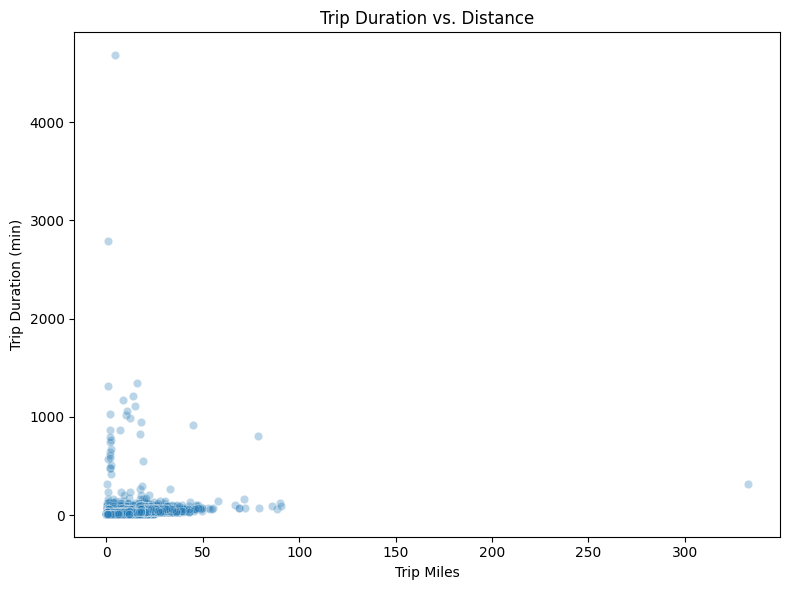

In [11]:
import seaborn as sns

# Filter out zeros or NaNs
df_scatter = df[(df["Trip Miles"] > 0) & (df["trip_duration_min"] > 0)]

# Sample for plotting speed
df_sample = df_scatter.sample(n=50_000, random_state=1)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_sample,
    x="Trip Miles", y="trip_duration_min", alpha=0.3
)
plt.title("Trip Duration vs. Distance")
plt.xlabel("Trip Miles")
plt.ylabel("Trip Duration (min)")
plt.tight_layout()
plt.show()


Top companies by trip count and average fare

                                   trip_count   avg_fare   avg_tip
Company                                                           
Taxi Affiliation Services             1338160  19.094695  2.172136
Flash Cab                             1175372  20.105592  1.683275
Yellow Cab                             535695  16.175396  1.682492
Chicago Carriage Cab Corp              519273  17.924327  2.233651
Sun Taxi                               461692  20.823897  3.023199
City Service                           447999  19.888529  2.714572
Medallion Leasin                       349098  20.137609  2.438271
Choice Taxi Association                302734  18.487926  2.642622
Dispatch Taxi Affiliation              270057  16.181954  1.948783
Taxi Affiliation Service Yellow        239366  18.139160  2.113013
Globe Taxi                             188195  19.334925  2.504865
Star North Management LLC              156238  17.717362  2.437988
Blue Ribbon Taxi Association Inc.      131528  21.030816  2.56

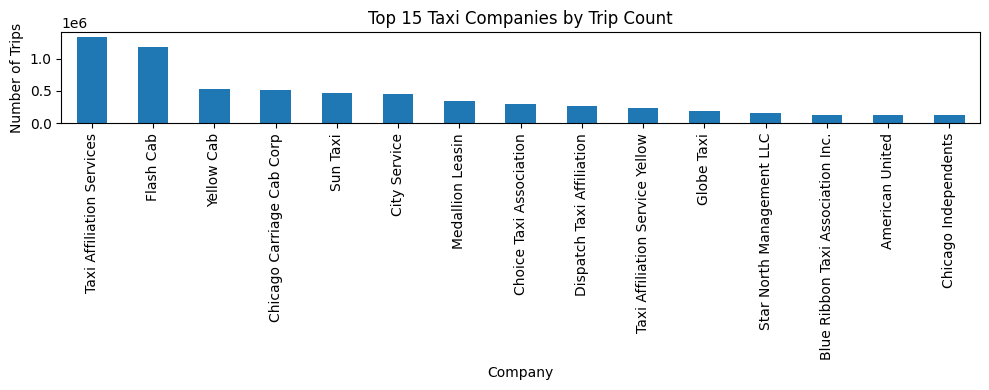

In [12]:
company_stats = (
    df.groupby("Company")
    .agg(
        trip_count = ("Trip Total", "count"),
        avg_fare = ("Fare", "mean"),
        avg_tip = ("Tips", "mean")
    )
    .sort_values("trip_count", ascending=False)
    .head(15)
)

print(company_stats)

# Plot top 15 companies by trip count
company_stats["trip_count"].plot(kind="bar", figsize=(10,4), title="Top 15 Taxi Companies by Trip Count")
plt.ylabel("Number of Trips")
plt.xlabel("Company")
plt.tight_layout()
plt.show()


Trips by payment type

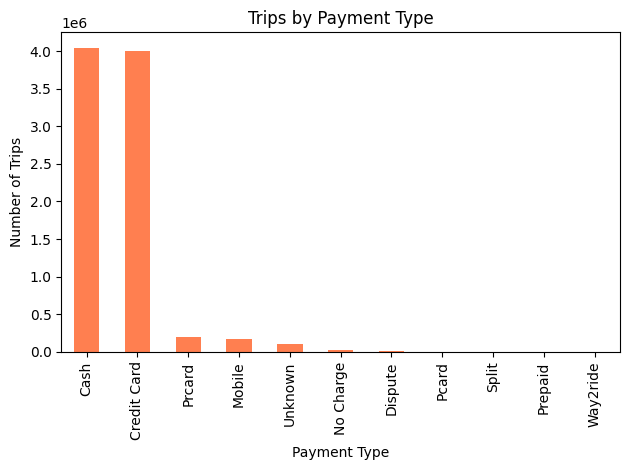

In [13]:
payment_summary = df["Payment Type"].value_counts()

payment_summary.plot(kind="bar", title="Trips by Payment Type", color="coral")
plt.ylabel("Number of Trips")
plt.xlabel("Payment Type")
plt.tight_layout()
plt.show()


Heatmap: hour vs. weekday (when are people riding?)

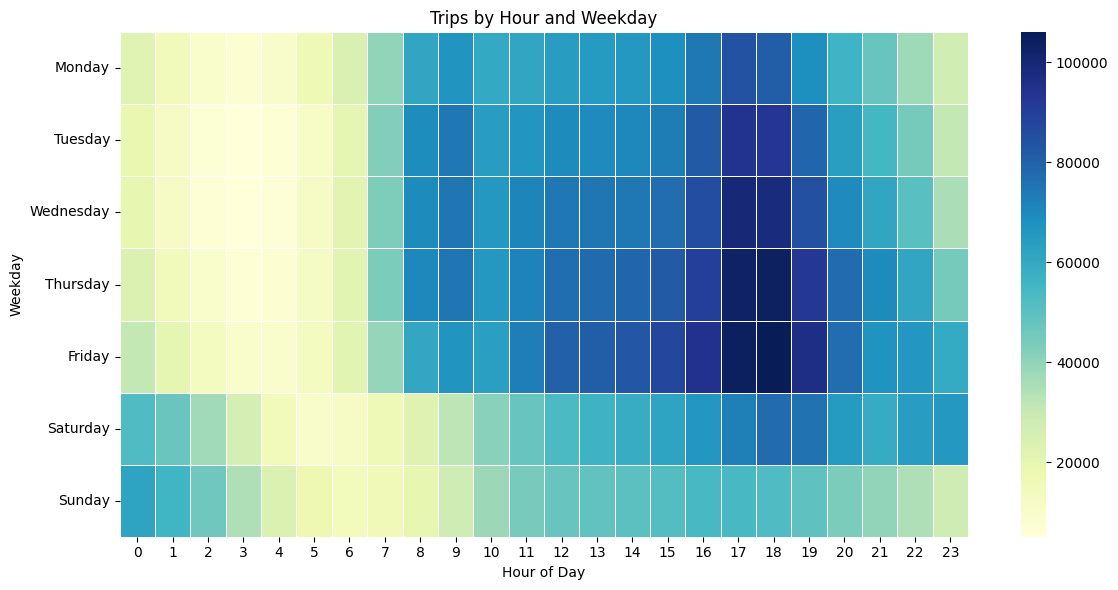

In [14]:
# Pivot: weekday (rows) vs. hour (columns)
heatmap_data = (
    df.groupby(["weekday", "start_hour"])
    .size()
    .unstack()
    .reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=False, linewidths=0.5)
plt.title("Trips by Hour and Weekday")
plt.xlabel("Hour of Day")
plt.ylabel("Weekday")
plt.tight_layout()
plt.show()


Detect unusually short or long trips

In [15]:
# Very short trips (<1 minute or <0.1 miles)
short_trips = df[(df["trip_duration_min"] < 1) | (df["Trip Miles"] < 0.1)]
print("Unusually short trips:", len(short_trips))

# Very long trips (>120 minutes or >50 miles)
long_trips = df[(df["trip_duration_min"] > 120) | (df["Trip Miles"] > 50)]
print("Unusually long trips:", len(long_trips))


Unusually short trips: 5026
Unusually long trips: 14152
